<a href="https://colab.research.google.com/github/Adedayo19/MIRNet/blob/main/MIRNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Add, Reshape
from keras.layers import Activation, BatchNormalization
# regularizers
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D, MaxPooling2D
from keras.layers import Concatenate

from keras.layers import LSTM, Bidirectional
from keras.utils import plot_model
from keras.layers import Dropout
from scipy import signal

tf.config.set_soft_device_placement(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DRNet/raw_jena_climate_2009_2016.csv")
df.head()

,DateTime,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),hour,DateTime.1
0,2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,1,2009-01-01 01:00:00
1,2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,2,2009-01-01 02:00:00
2,2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,3,2009-01-01 03:00:00
3,2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,4,2009-01-01 04:00:00
4,2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,5,2009-01-01 05:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70092 entries, 0 to 70091
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         70092 non-null  object 
 1   Date Time        70092 non-null  object 
 2   p (mbar)         70092 non-null  float64
 3   T (degC)         70092 non-null  float64
 4   Tpot (K)         70092 non-null  float64
 5   Tdew (degC)      70092 non-null  float64
 6   rh (%)           70092 non-null  float64
 7   VPmax (mbar)     70092 non-null  float64
 8   VPact (mbar)     70092 non-null  float64
 9   VPdef (mbar)     70092 non-null  float64
 10  sh (g/kg)        70092 non-null  float64
 11  H2OC (mmol/mol)  70092 non-null  float64
 12  rho (g/m**3)     70092 non-null  float64
 13  wv (m/s)         70092 non-null  float64
 14  max. wv (m/s)    70092 non-null  float64
 15  wd (deg)         70092 non-null  float64
 16  hour             70092 non-null  int64  
 17  DateTime.1  

In [ ]:
df['T (degC)'].describe()

count    70092.000000
mean         9.449504
std          8.422546
min        -22.760000
25%          3.350000
50%          9.420000
75%         15.470000
max         37.280000
Name: T (degC), dtype: float64

In [ ]:

weather_num = df.select_dtypes(include = ['float64', 'int64'])
weather_num_corr = weather_num.corr()['T (degC)']
# weather_num_corr = weather_num.corr()
print(weather_num_corr)
# top_features = weather_num_corr[abs(weather_num_corr) > 0.5].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
# print("There is {} strongly correlated values with Temp:\n{}".format(len(top_features), top_features))

p (mbar)          -0.045414
T (degC)           1.000000
Tpot (K)           0.996826
Tdew (degC)        0.895729
rh (%)            -0.572134
VPmax (mbar)       0.951109
VPact (mbar)       0.867698
VPdef (mbar)       0.761670
sh (g/kg)          0.866781
H2OC (mmol/mol)    0.867205
rho (g/m**3)      -0.963408
wv (m/s)          -0.004956
max. wv (m/s)     -0.003927
wd (deg)           0.039643
hour               0.164616
Name: T (degC), dtype: float64


In [ ]:
correlation_matrix = df.select_dtypes(include = ['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)

# Display the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
data= df[['T (degC)','Tpot (K)','VPmax (mbar)','Tdew (degC)', 'VPact (mbar)','H2OC (mmol/mol)', 'sh (g/kg)']]
temp_data = df[['T (degC)']]
temp_data.head()

,T (degC)
0,-8.05
1,-8.88
2,-8.81
3,-9.05
4,-9.63


In [ ]:
def create_dataset(dataset, timesteps):
  dataX = []
  dataY = []
  for i in range(len(dataset)-timesteps - 1):
    row = [r for r in dataset[i:i+timesteps]]
    dataX.append(row)
    label = dataset[i+timesteps, 0]
    dataY.append(label)
  return np.array(dataX), np.array(dataY)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mses.append(logs.get('mse'))
        self.maes.append(logs.get('mae'))
        self.mapes.append(logs.get('mape'))
        self.val_mses.append(logs.get('val_mse'))
        self.val_maes.append(logs.get('val_mae'))
        self.val_mapes.append(logs.get('val_mape'))


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
temp_data = scaler.fit_transform(temp_data)
print(temp_data.shape)

(70091, 1)


In [ ]:
print(data[:100])

[[0.24500333 0.24072233 0.03757962 0.33472628 0.08491254 0.08378088
  0.08257403]
 [0.23117921 0.22680583 0.03423567 0.31404095 0.07616618 0.07518797
  0.07403189]
 [0.2323451  0.22763419 0.0343949  0.31633932 0.07725948 0.07626208
  0.07517084]
 [0.22834777 0.22349238 0.03343949 0.30881738 0.07434402 0.07303974
  0.07232346]
 [0.21868754 0.21322068 0.03136943 0.29565399 0.06924198 0.06802721
  0.06719818]
 [0.21802132 0.21222664 0.03121019 0.29628082 0.06924198 0.06838525
  0.06719818]
 [0.2263491  0.21984758 0.03296178 0.30714584 0.07361516 0.07232367
  0.07118451]
 [0.24417055 0.23641484 0.03726115 0.32908483 0.08236152 0.08127462
  0.08029613]
 [0.251499   0.24304175 0.03917197 0.33347263 0.0845481  0.0830648
  0.08200456]
 [0.26182545 0.25265076 0.04187898 0.34747179 0.09074344 0.08879341
  0.08769932]
 [0.25566289 0.24569251 0.04028662 0.3372336  0.08600583 0.08449696
  0.08314351]
 [0.2646569  0.2554672  0.04251592 0.34517342 0.08965015 0.0877193
  0.08656036]
 [0.28097935 0.272

In [ ]:
total_samples = len(data)
train_samples = int(0.7 * total_samples)
validation_samples = int(0.2 * total_samples)
test_samples = total_samples - train_samples - validation_samples

Training_set = data[:train_samples]
Validation_set = data[train_samples:train_samples + validation_samples]
Test_set = data[train_samples + validation_samples:]

Training_set.shape, Validation_set.shape, Test_set.shape

((49063, 7), (14018, 7), (7010, 7))

In [ ]:
# For temp alone
total_temp_samples = len(temp_data)
train_temp_samples = int(0.7 * total_temp_samples)
validation_temp_samples = int(0.2 * total_temp_samples)
test_temp_samples = total_temp_samples - train_temp_samples - validation_temp_samples

Training_temp_set = temp_data[:train_temp_samples]
Validation_temp_set = temp_data[train_temp_samples:train_temp_samples + validation_temp_samples]
Test_temp_set = temp_data[train_temp_samples + validation_temp_samples:]

Training_temp_set.shape, Validation_temp_set.shape, Test_temp_set.shape

((49063, 1), (14018, 1), (7010, 1))

In [ ]:
features = 7
timesteps = 48

In [ ]:
trainX, trainY = create_dataset(Training_set, timesteps)
validX, validY = create_dataset(Validation_set, timesteps)
testX, testY = create_dataset(Test_set, timesteps)

In [ ]:
train_temp_X, train_temp_Y = create_dataset(Training_temp_set, timesteps)
valid_temp_X, valid_temp_Y = create_dataset(Validation_temp_set, timesteps)
test_temp_X, test_temp_Y = create_dataset(Test_temp_set, timesteps)

In [ ]:
trainX.shape, validX.shape, testX.shape, train_temp_X.shape, valid_temp_X.shape

((49014, 48, 7), (13969, 48, 7), (6961, 48, 7), (49014, 48, 1), (13969, 48, 1))

In [ ]:
filename="sunday-4-"

with tf.device('/gpu:0'):

    visible1 = Input(shape=(timesteps, 1), name='visible1')
    visible_conv = Input(shape=(timesteps, features, 1), name='visible_conv')

      # Adjust input shape for 2D data
    con201 = Conv2D(filters=48, kernel_size=(24,2), padding='same', name='con201')(visible_conv)
    con202 = Conv2D(filters=96, kernel_size=(24,1), padding='same', name='con202')(con201)
    con203 = Conv2D(filters=96, kernel_size=(12,1), padding='same', name='con203')(con202)
    max_pool1 = MaxPooling2D((2, 2), padding='same')(con203)
    con211 = Conv2D(filters=48, kernel_size=(6,3), padding='same', name='con211')(max_pool1)
    con212 = Conv2D(filters=96, kernel_size=(6,2), padding='same', name='con212')(con211)
    con213 = Conv2D(filters=160, kernel_size=(6,1), padding='same', name='con213')(con212)
    max_pool2 = MaxPooling2D((2, 2),padding='same')(con213)
    con221 = Conv2D(filters=256, kernel_size=(3, 1), padding='same', name='con221')(max_pool2)
    max_pool3 = MaxPooling2D((2, 2),padding='same')(con221)
    con231 = Conv2D(filters=256, kernel_size=(1, 1), padding='same', name='con231')(max_pool3)

    # Concatenate the outputs of 2D CNN layers along the depth axis
    # concat_output = Concatenate(axis=-1)([con201, con211, con221])
    # max_pool1 = MaxPooling2D((2, 2))(con211)
    # Flatten the concatenated output
    flattened_output = Flatten()(con231)

    reshaped_for_con10 = Reshape(target_shape=(timesteps, -1))(flattened_output)

    con10 = Conv1D(filters=96, kernel_size=5, strides=1, padding='causal', name='con10')(visible1)
    con10 = Activation('selu', name='activation_10')(con10)

    bi11 = Bidirectional(LSTM(32, return_sequences=True), name='bi11')(con10)
    bi12 = Bidirectional(LSTM(32, return_sequences=True), name='bi12')(bi11)
    con11 = Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', name='con11')(bi12)
    con11 = Activation('selu', name='activation_20')(con11)
    res13 = Concatenate(name='concat_1')([bi12, con11, reshaped_for_con10, visible1])
    con20 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name='con20')(res13)
    con20 = Activation('selu', name='activation_30')(con20)

    bi13 = Bidirectional(LSTM(32, return_sequences=True), name='bi13')(res13)
    bi14 = Bidirectional(LSTM(32, return_sequences=True), name='bi14')(bi13)
    con12 = Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', name='con12')(bi14)
    con12 = Activation('selu', name='activation_40')(con12)
    res14 = Concatenate(name='concat_2')([res13, con20, bi14, con12, reshaped_for_con10, visible1])
    con21 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name='con21')(res14)
    con21 = Activation('selu', name='activation_50')(con21)

    bi15 = Bidirectional(LSTM(32, return_sequences=True), name='bi15')(res14)
    bi16 = Bidirectional(LSTM(32, return_sequences=True), name='bi16')(bi15)
    con13 = Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', name='con13')(bi16)
    con13 = Activation('selu', name='activation_60')(con13)
    res15 = Concatenate(name='concat_3')([res14, con21, bi16, con13, reshaped_for_con10, visible1])
    con22 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name='con22')(res15)
    con22 = Activation('selu', name='activation_70')(con22)

    bi17 = Bidirectional(LSTM(32, return_sequences=True), name='bi17')(res15)
    bi18 = Bidirectional(LSTM(32, return_sequences=True), name='bi18')(bi17)
    con14 = Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', name='con14')(bi18)
    con14 = Activation('selu', name='activation_80')(con14)
    res16 = Concatenate(name='concat_4')([res15, con22, bi18, con14, reshaped_for_con10, visible1])
    con23 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name='con23')(res16)
    con23 = Activation('selu', name='activation_90')(con23)

    bi19 = Bidirectional(LSTM(32, return_sequences=True), name='bi19')(res16)
    bi20 = Bidirectional(LSTM(32, return_sequences=True), name='bi20')(bi19)
    con15 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name='con15')(bi20)
    con15 = Activation('selu', name='activation_100')(con15)
    res17 = Concatenate(name='concat_5')([res16, con23, bi20, con15, reshaped_for_con10, visible1])

    bi21 = Bidirectional(LSTM(128), name='bi21')(res17)

    dense11 = Dense(48, activation='selu', name='dense11')(bi21)
    out1 = Dense(1, activation='selu', name='out1')(dense11)

    model = Model(inputs=[visible1, visible_conv], outputs=[out1])

2023-08-27 15:59:43.843073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46802 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:02:00.0, compute capability: 7.5


In [ ]:
print('Shape of trainX = {} Shape of train_temp_X = {}'.format(trainX.shape, train_temp_X.shape))
print(model.summary())
#plot_model(model, to_file='MDRNet_exp_1_II_Structure.jpg')

Shape of trainX = (49014, 48, 7) Shape of train_temp_X = (49014, 48, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 visible_conv (InputLayer)   [(None, 48, 7, 1)]           0         []                            
                                                                                                  
 con201 (Conv2D)             (None, 48, 7, 48)            2352      ['visible_conv[0][0]']        
                                                                                                  
 con202 (Conv2D)             (None, 48, 7, 96)            110688    ['con201[0][0]']              
                                                                                                  
 con203 (Conv2D)             (None, 48, 7, 96)            110688    ['con202[0][0]']              
                      

 activation_60 (Activation)  (None, 48, 128)              0         ['con13[0][0]']               
                                                                                                  
 concat_3 (Concatenate)      (None, 48, 931)              0         ['concat_2[0][0]',            
                                                                     'activation_50[0][0]',       
                                                                     'bi16[0][0]',                
                                                                     'activation_60[0][0]',       
                                                                     'reshape[0][0]',             
                                                                     'visible1[0][0]']            
                                                                                                  
 bi17 (Bidirectional)        (None, 48, 64)               246784    ['concat_3[0][0]']            
          

In [ ]:
cp_best = ModelCheckpoint(filepath=filename+'best_model.h5', monitor='val_mse', save_best_only=True, verbose=1)
log = CSVLogger(filename+'_history.csv')

Epoch 1/100


2023-08-27 16:00:34.096015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-27 16:00:36.456688: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eff301fba70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-27 16:00:36.456727: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-08-27 16:00:36.463101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-27 16:00:36.655771: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 [==============================] - ETA: 0s - loss: 0.0699 - mse: 0.0699 - mae: 0.0799 - mape: 2167.9028
Epoch 1: val_mse improved from inf to 0.00102, saving model to sunday-4-best_model.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


491/491 [==============================] - 100s 99ms/step - loss: 0.0699 - mse: 0.0699 - mae: 0.0799 - mape: 2167.9028 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0237 - val_mape: 4.2219 - lr: 0.0010
Epoch 2/100
491/491 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014 - mae: 0.0282 - mape: 5436.9062
Epoch 2: val_mse improved from 0.00102 to 0.00059, saving model to sunday-4-best_model.h5
491/491 [==============================] - 39s 79ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0282 - mape: 5436.9062 - val_loss: 5.8890e-04 - val_mse: 5.8890e-04 - val_mae: 0.0196 - val_mape: 4.0609 - lr: 0.0010
Epoch 3/100
491/491 [==============================] - ETA: 0s - loss: 9.8690e-04 - mse: 9.8690e-04 - mae: 0.0227 - mape: 1077.9678
Epoch 3: val_mse improved from 0.00059 to 0.00034, saving model to sunday-4-best_model.h5
491/491 [==============================] - 38s 78ms/step - loss: 9.8690e-04 - mse: 9.8690e-04 - mae: 0.0227 - mape: 1077.9678 - val_loss: 3.3941e

Epoch 21/100
491/491 [==============================] - ETA: 0s - loss: 1.4070e-04 - mse: 1.4070e-04 - mae: 0.0083 - mape: 614.2576
Epoch 21: val_mse did not improve from 0.00014
491/491 [==============================] - 38s 77ms/step - loss: 1.4070e-04 - mse: 1.4070e-04 - mae: 0.0083 - mape: 614.2576 - val_loss: 1.5691e-04 - val_mse: 1.5691e-04 - val_mae: 0.0091 - val_mape: 1.6999 - lr: 2.8147e-05
Epoch 22/100
491/491 [==============================] - ETA: 0s - loss: 1.4013e-04 - mse: 1.4013e-04 - mae: 0.0082 - mape: 603.2236
Epoch 22: val_mse did not improve from 0.00014
491/491 [==============================] - 38s 77ms/step - loss: 1.4013e-04 - mse: 1.4013e-04 - mae: 0.0082 - mape: 603.2236 - val_loss: 1.6275e-04 - val_mse: 1.6275e-04 - val_mae: 0.0094 - val_mape: 1.7642 - lr: 2.2518e-05
Epoch 23/100
491/491 [==============================] - ETA: 0s - loss: 1.4027e-04 - mse: 1.4027e-04 - mae: 0.0083 - mape: 549.8583
Epoch 23: val_mse improved from 0.00014 to 0.00013, saving mod

491/491 [==============================] - ETA: 0s - loss: 1.3028e-04 - mse: 1.3028e-04 - mae: 0.0078 - mape: 678.1656
Epoch 41: val_mse did not improve from 0.00013
491/491 [==============================] - 38s 77ms/step - loss: 1.3028e-04 - mse: 1.3028e-04 - mae: 0.0078 - mape: 678.1656 - val_loss: 1.4013e-04 - val_mse: 1.4013e-04 - val_mae: 0.0083 - val_mape: 1.6216 - lr: 3.2452e-07
Epoch 42/100
491/491 [==============================] - ETA: 0s - loss: 1.2946e-04 - mse: 1.2946e-04 - mae: 0.0078 - mape: 647.4678
Epoch 42: val_mse improved from 0.00013 to 0.00013, saving model to sunday-4-best_model.h5
491/491 [==============================] - 38s 78ms/step - loss: 1.2946e-04 - mse: 1.2946e-04 - mae: 0.0078 - mape: 647.4678 - val_loss: 1.3424e-04 - val_mse: 1.3424e-04 - val_mae: 0.0080 - val_mape: 1.5449 - lr: 2.5961e-07
Epoch 43/100
491/491 [==============================] - ETA: 0s - loss: 1.2880e-04 - mse: 1.2880e-04 - mae: 0.0077 - mape: 621.8231
Epoch 43: val_mse improved from

Epoch 60/100
491/491 [==============================] - ETA: 0s - loss: 1.2729e-04 - mse: 1.2729e-04 - mae: 0.0076 - mape: 592.9355
Epoch 60: val_mse improved from 0.00013 to 0.00013, saving model to sunday-4-best_model.h5
491/491 [==============================] - 38s 78ms/step - loss: 1.2729e-04 - mse: 1.2729e-04 - mae: 0.0076 - mape: 592.9355 - val_loss: 1.2752e-04 - val_mse: 1.2752e-04 - val_mae: 0.0076 - val_mape: 1.4528 - lr: 5.8460e-09
Epoch 61/100
491/491 [==============================] - ETA: 0s - loss: 1.2729e-04 - mse: 1.2729e-04 - mae: 0.0076 - mape: 592.8960
Epoch 61: val_mse improved from 0.00013 to 0.00013, saving model to sunday-4-best_model.h5
491/491 [==============================] - 38s 78ms/step - loss: 1.2729e-04 - mse: 1.2729e-04 - mae: 0.0076 - mape: 592.8960 - val_loss: 1.2752e-04 - val_mse: 1.2752e-04 - val_mae: 0.0076 - val_mape: 1.4528 - lr: 4.6768e-09
Epoch 62/100
491/491 [==============================] - ETA: 0s - loss: 1.2729e-04 - mse: 1.2729e-04 - mae

Epoch 79/100
491/491 [==============================] - ETA: 0s - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0283
Epoch 79: val_mse did not improve from 0.00013
491/491 [==============================] - 38s 77ms/step - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0283 - val_loss: 1.2751e-04 - val_mse: 1.2751e-04 - val_mae: 0.0076 - val_mape: 1.4527 - lr: 8.4250e-11
Epoch 80/100
491/491 [==============================] - ETA: 0s - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0297
Epoch 80: val_mse did not improve from 0.00013
491/491 [==============================] - 38s 77ms/step - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0297 - val_loss: 1.2751e-04 - val_mse: 1.2751e-04 - val_mae: 0.0076 - val_mape: 1.4527 - lr: 6.7400e-11
Epoch 81/100
491/491 [==============================] - ETA: 0s - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0297
Epoch 81: val_mse did not improve from 0.00013
491/491 [======

491/491 [==============================] - ETA: 0s - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0283
Epoch 99: val_mse did not improve from 0.00013
491/491 [==============================] - 38s 77ms/step - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0283 - val_loss: 1.2751e-04 - val_mse: 1.2751e-04 - val_mae: 0.0076 - val_mape: 1.4527 - lr: 9.7133e-13
Epoch 100/100
491/491 [==============================] - ETA: 0s - loss: 1.2728e-04 - mse: 1.2728e-04 - mae: 0.0076 - mape: 592.0251
Epoch 100: val_mse did not improve from 0.00013
70/70 [==============================] - 2s 31ms/step
--------------------------------------------------------
 history.mses(=loss) =  [0.06988698989152908, 0.0013962039956822991, 0.0009868975030258298, 0.0008459902601316571, 0.0004481649666558951, 0.0005837154458276927, 0.0003432330267969519, 0.0002863752597477287, 0.0002477419620845467, 0.00020913370826747268, 0.00018927420023828745, 0.00018032595107797533, 0.00017370219575

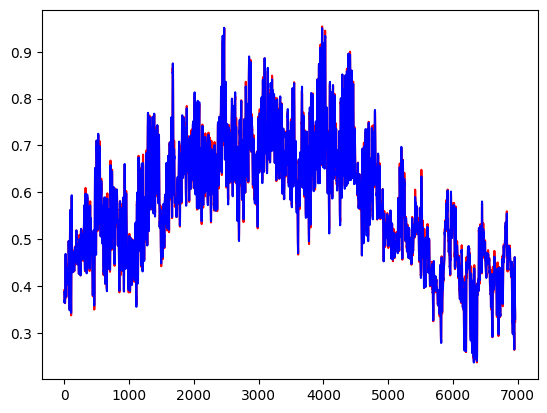

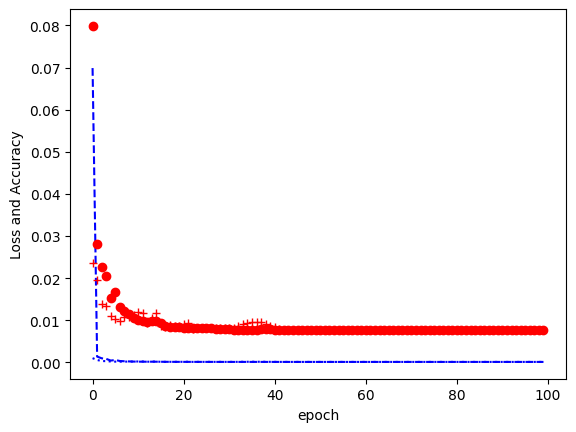

Test Score > MSE ==  0.00012291698515578864  MAE ==  0.007688562967449483 MAPE ==  1.3566752437401055


In [ ]:
from keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)  # tuning learning rate

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape',])

batch_size = 100
epochs = 100

history = LossHistory()
# history.init()

model.fit([train_temp_X, trainX], trainY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=([valid_temp_X, validX], validY), callbacks=[history, cp_best, log, reducelr])  # , checkpoint

trainPredict = model.predict([train_temp_X, trainX], batch_size=batch_size)
testPredict = model.predict([test_temp_X, testX], batch_size=batch_size)

trainPredict = trainPredict.reshape([-1])
testPredict = testPredict.reshape([-1])
testY = testY.reshape([-1])
trainY = trainY.reshape([-1])



print('--------------------------------------------------------')
print(' history.mses(=loss) = ', history.mses)  # loss == mse
print(' history.maes        = ', history.maes)
print(' history.mapes        = ', history.mapes)
print(' history.val_mses(=loss)= ', history.val_mses)  # loss == mse
print(' history.val_maes       = ', history.val_maes)
print(' history.val_mapes       = ', history.val_mapes)
print('--------------------------------------------------------')

plt.figure(1)
plt.plot(testPredict, 'r')
plt.plot(testY, 'b')
plt.show()

plt.figure(2)
plt.plot(history.mses, 'b--')
plt.plot(history.val_mses, 'b:')
plt.plot(history.maes, 'ro')
plt.plot(history.val_maes, 'r+')
plt.ylabel('Loss and Accuracy')
plt.xlabel('epoch')
plt.show()

print('Test Score > MSE == ', mean_squared_error(testY, testPredict), ' MAE == ', mean_absolute_error(testY, testPredict), 'MAPE == ', mean_absolute_percentage_error(testY, testPredict))

In [ ]:
#filename="sunday-3-"
model_path= filename+'best_model.h5'

In [ ]:
from keras.models import load_model
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
#batch_size=100
# Load and evaluate each LSTM variation
results = []
model = load_model(model_path)
# Compile the model
mse = MeanSquaredError()
rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

testPredict = model.predict([test_temp_X, testX],batch_size=batch_size)
mse.update_state(testY, testPredict)
rmse.update_state(testY, testPredict)
mae.update_state(testY, testPredict)

mse_result = mse.result().numpy()
rmse_result = rmse.result().numpy()
mae_result = mae.result().numpy()

results.append({
    'MSE': mse_result,
    'RMSE': rmse_result,
    'MAE': mae_result
})

# Save the evaluation results in a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv(filename+"_evaluation.csv", index=False)


70/70 [==============================] - 11s 27ms/step


In [ ]:
evaluation = pd.read_csv(filename+"_evaluation.csv")

In [ ]:
evaluation.head()

,MSE,RMSE,MAE
0,0.000123,0.011087,0.007689
